In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr

In [2]:
import pysal as ps

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
import spopt

In [4]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [5]:
opt_tim=0. # select observations around this time (hrs) in the time-window (0==analysis-time)
opt_pre=250. # select observations around this pressure-level (hPa)
# Select subset of data from lat, lon, prs, tim: 
idx=np.where((ob_use==1.)&
             (np.abs(ob_pre-opt_pre)<25.)&
             (np.abs(ob_tim-opt_tim)<0.5)
            )[0]
# Construct a geopandas point dataset 
point_list=[]
for i in idx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 'lat': list(ob_lat[idx]) , 'lon': list(ob_lon[idx]), 'ob_idx': list(idx)}
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")

In [6]:
# Let's get the uwd, vwd, and geopotential height (hgt) for opt_pre
grib_file=data_dir+'/gdas.t00z.pgrb2.0p25.anl'
grib=xr.load_dataset(grib_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
grib_levs=grib.variables['isobaricInhPa'].values
glev_idx=np.where(grib_levs==opt_pre)
grib_uwd=grib.variables['u'].values[glev_idx,:,:].squeeze()
grib_vwd=grib.variables['v'].values[glev_idx,:,:].squeeze()
grib_hgt=grib.variables['gh'].values[glev_idx,:,:].squeeze()

skipping variable: paramId==260018 shortName='clwmr'
Traceback (most recent call last):
  File "/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500

In [7]:
grib_lat=grib.variables['latitude'].values
grib_lon=grib.variables['longitude'].values
# For whatever reason, cartopy does not like grib_lon in (-180.,180.) format
fix=np.where(grib_lon<0.)
grib_lon[fix]=grib_lon[fix]+360.

In [202]:
# Assign obs to hexes of a chosen resolution hexgrid
def assign_h3(df, resolution):
    #df[f'h3_{resolution}'] = df.apply(lambda row: h3.h3_to_string(h3.geo_to_h3(row['lat'], row['lon'], resolution)), axis=1)
    df[f'h3_cell'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], resolution), axis=1)
res=1
assign_h3(gdf, res)

In [203]:
# Generate a list of all h3{res} cells not in gdf
h3r0hexes=h3.get_res0_indexes()
h3hexes=[]
for hx in h3r0hexes:
    h3hexes.extend(list(h3.h3_to_children(hx,res=res)))
h3all=np.asarray(h3hexes)
print('{:d} total hexes at res={:d}'.format(np.size(h3all),res))

h3Filled=np.unique(gdf['h3_cell'].values).astype(h3all.dtype)
print('{:d} filled hexes at res={:d}'.format(np.size(h3Filled),res))

#full=np.where(np.isin(h3all,np.unique(gdf['h3_cell'].values)))
full=np.where(np.isin(h3all,h3Filled))
empty=np.setdiff1d(np.arange(np.size(h3all)),full)
h3empty=h3all[empty]
print('{:d} empty hexes at res={:d}'.format(np.size(h3empty),res))

h3comp=h3.compact(h3empty)
print('{:d} compacted empty hexes at res<={:d}'.format(np.size(h3comp),res))

h3Mosaic=np.append(h3Filled,h3comp)
print('{:d} total compacted hexes at res<={:d}'.format(np.size(h3Mosaic),res))

842 total hexes at res=1
518 filled hexes at res=1
324 empty hexes at res=1
230 compacted empty hexes at res<=1
748 total compacted hexes at res<=1


In [204]:
# Generate list of h3Filled polygons, and convert to a MultiPolygon
# NOTE: The use of h3.h3_set_to_multipolygon() implies I should be able to do this in one step,
#       but so far I just run into an endless revolving-door of errors.
h3MosaicPolys=[]
for hx in h3Mosaic:
    h3MosaicPolys.append(Polygon(h3.h3_set_to_multi_polygon([hx])[0][0]))
h3MosaicMultiPoly=MultiPolygon(h3MosaicPolys)

In [205]:
# Generate list of h3Filled polygons, and convert to a MultiPolygon
# NOTE: The use of h3.h3_set_to_multipolygon() implies I should be able to do this in one step,
#       but so far I just run into an endless revolving-door of errors.
h3FilledPolys=[]
for hx in h3Filled:
    h3FilledPolys.append(Polygon(h3.h3_set_to_multi_polygon([hx])[0][0]))
h3FilledMultiPoly=MultiPolygon(h3FilledPolys)

In [206]:
# Generate plots for h3FilledMultiPoly and h3MosaicMultiPoly
proj=ccrs.PlateCarree()
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

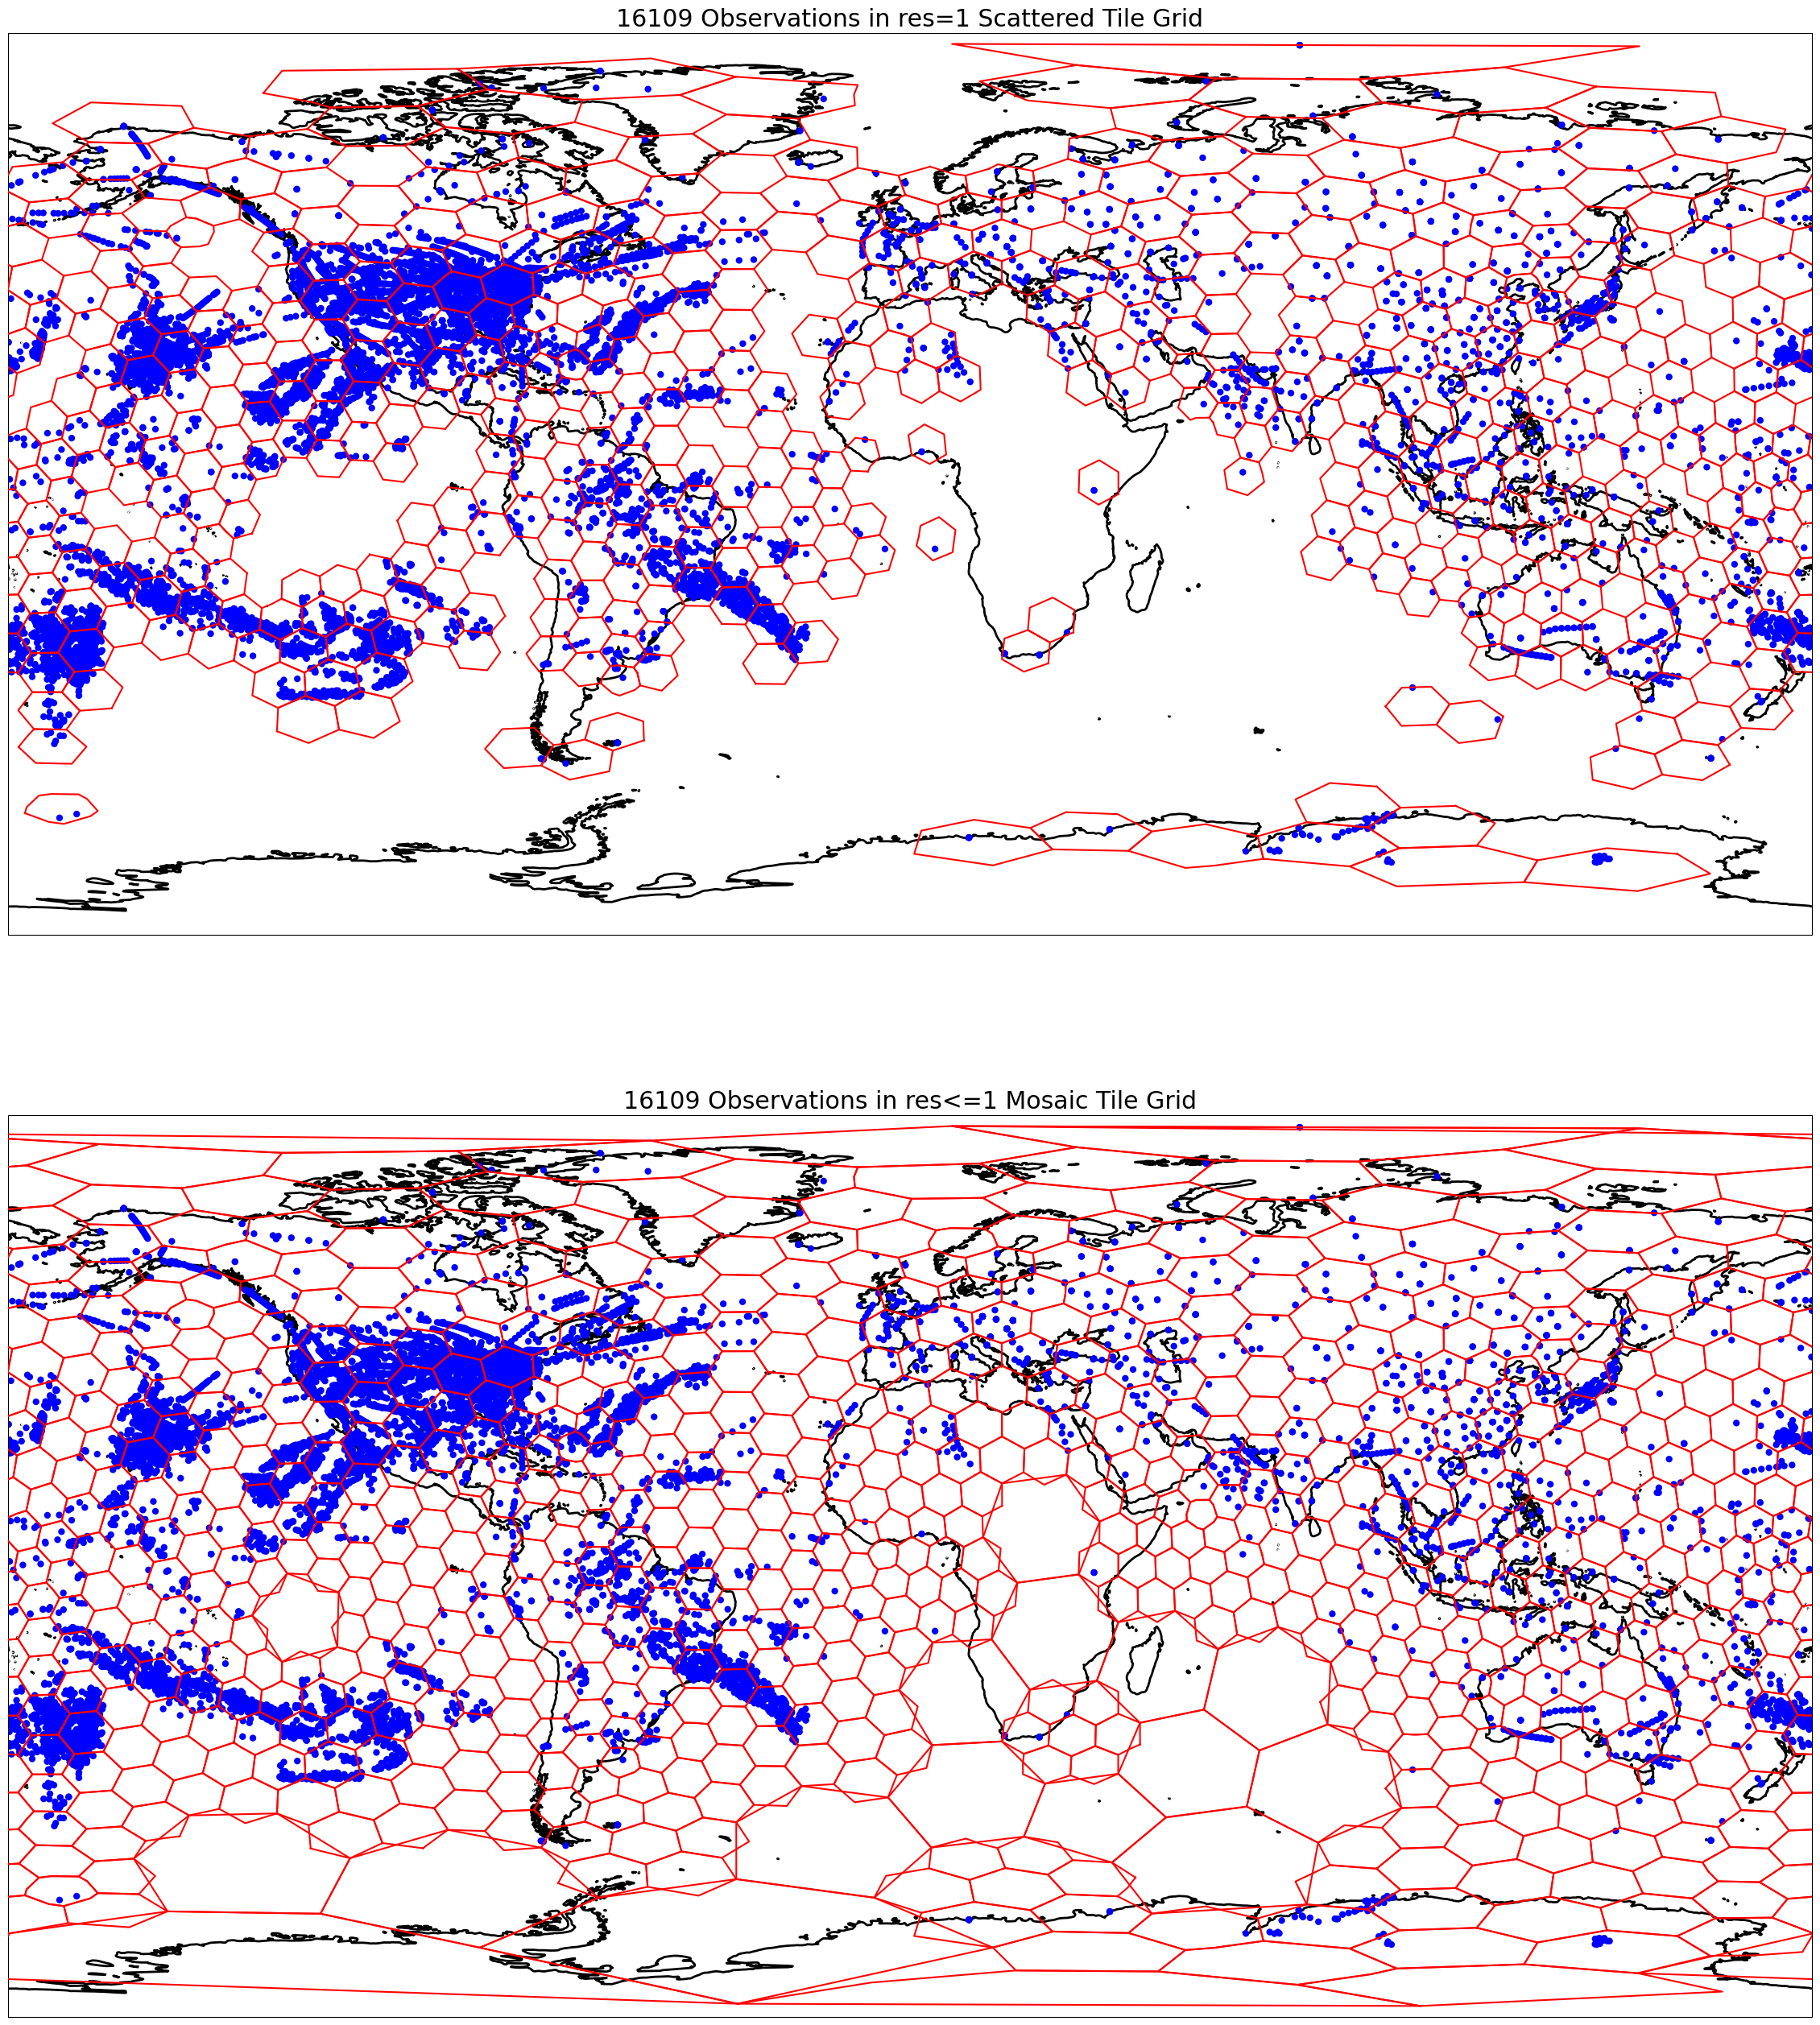

In [207]:
fig,(ax1,ax2)=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=2,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,32)
                   )
ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3FilledMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax1.plot(*polyg,color='red',transform=proj,zorder=3)
# Plot obs data on top
sca=ax1.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=2
          )
ax1.set_global()
ax1.set_title('{:d} Observations in res={:d} Scattered Tile Grid'.format(np.size(idx),res))

ax2.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3MosaicMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax2.plot(*polyg,color='red',transform=proj,zorder=3)
# Plot obs data on top
sca=ax2.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=2
          )
ax2.set_global()
ax2.set_title('{:d} Observations in res<={:d} Mosaic Tile Grid'.format(np.size(idx),res))

plt.show()

In [208]:
# Construct a geopandas dataframe with each unique h3 cell
d = {'geometry': h3FilledPolys,'h3_cell': np.unique(gdf['h3_cell'].values)}
n_obs=[]
n_typ=[]
u_mean=[]
v_mean=[]
u_stdv=[]
v_stdv=[]
p_mean=[]
p_stdv=[]
t_mean=[]
t_stdv=[]

for cell in d['h3_cell']:
    ids=gdf.loc[gdf['h3_cell']==cell]['ob_idx']
    n_obs.append(len(ids))
    u_mean.append(np.mean(ob_uwd[ids]))
    v_mean.append(np.mean(ob_vwd[ids]))
    p_mean.append(np.mean(ob_pre[ids]))
    t_mean.append(np.mean(ob_tim[ids]))
d['nobs']=n_obs
d['uavg']=u_mean
d['vavg']=v_mean
d['pavg']=p_mean
d['tavg']=t_mean
cellframe = gpd.GeoDataFrame(d, crs="EPSG:4326")
cellframe

geometry             h3_cell  \
0    POLYGON ((83.59755 33.23853, 80.34595 13.88006...  580968749977305087   
1    POLYGON ((73.26747 67.04817, 72.97478 82.21912...  580977546070327295   
2    POLYGON ((80.74027 89.55466, 83.15405 118.5766...  580981944116838399   
3    POLYGON ((73.26747 67.04817, 76.66744 55.65377...  580995138256371711   
4    POLYGON ((78.00336 -129.04689, 76.19876 -119.3...  581003934349393919   
..                                                 ...                 ...   
513  POLYGON ((-65.72439 -176.62192, -67.46843 -171...  585085321511698431   
514  POLYGON ((-73.85618 153.13248, -72.70831 139.0...  585124903930298367   
515  POLYGON ((-68.55155 91.34531, -67.53592 79.178...  585199670720987135   
516  POLYGON ((-74.83432 70.54359, -70.32657 69.389...  585204068767498239   
517  POLYGON ((-72.20471 113.09550, -72.71199 97.66...  585217262907031551   

     nobs       uavg       vavg        pavg      tavg  
0       3   9.066667 -14.700000  248.333328  0.030380  
1       2  13.350000  -5.600000  257.000000  0.018475  
2       3  -6.666667  -7.933333  244.333328  0.033997  
3       2  11.100000 -15.900000  257.000000  0.030165  
4       3   3.233334  -1.700000  249.533325 -0.209687  
..    ...        ...        ...         ...       ...  
513     2   6.905931 -22.296051  262.000000 -0.100000  
514    14  -5.690966  -9.601577  264.542877 -0.050000  
515    23  -2.537005 -22.026915  267.182617  0.100009  
516     1 -12.341522 -14.708054  262.000000  0.483333  
517     3  18.537214   9.896284  250.000000  0.483333  

[518 rows x 7 columns]

In [20]:
# Construct a geopandas dataframe with each unique h3 cell
d = {'geometry': h3MosaicPolys,'h3_cell': h3Mosaic}
n_obs=[]
n_typ=[]
u_mean=[]
v_mean=[]
u_stdv=[]
v_stdv=[]
p_mean=[]
p_stdv=[]
t_mean=[]
t_stdv=[]

for cell in d['h3_cell']:
    ids=gdf.loc[gdf['h3_cell']==cell]['ob_idx']
    if len(ids)==0:
        u_mean.append(-9999.)
        v_mean.append(-9999.)
        p_mean.append(-9999.)
        t_mean.append(-9999.)
        n_obs.append(2.)
        #u_mean.append(None)
        #v_mean.append(None)
        #p_mean.append(None)
        #t_mean.append(None)
    else:
        n_obs.append(len(ids))
        u_mean.append(np.mean(ob_uwd[ids]))
        v_mean.append(np.mean(ob_vwd[ids]))
        p_mean.append(np.mean(ob_pre[ids]))
        t_mean.append(np.mean(ob_tim[ids]))
d['nobs']=n_obs
d['uavg']=u_mean
d['vavg']=v_mean
d['pavg']=p_mean
d['tavg']=t_mean
cellframe = gpd.GeoDataFrame(d, crs="EPSG:4326")
cellframe

geometry             h3_cell  \
0     POLYGON ((73.76987 87.35477, 75.49759 87.70559...  585478396918628351   
1     POLYGON ((79.55833 55.75077, 78.02572 59.68414...  585480046186070015   
2     POLYGON ((88.49939 58.38445, 86.84371 72.35463...  585482245209325567   
3     POLYGON ((71.09901 55.54935, 72.37448 58.22987...  585494889593044991   
4     POLYGON ((81.22981 -91.36676, 80.31934 -100.21...  585506434465136639   
...                                                 ...                 ...   
3862  POLYGON ((-62.49216 -34.66386, -66.19292 -7.13...  580366217605283839   
3863  POLYGON ((-11.22288 41.57956, -22.88597 37.281...  579345870814707711   
3864  POLYGON ((-49.37212 -126.32951, -49.77934 -143...  580471770721550335   
3865  POLYGON ((-48.29532 98.08037, -37.09959 95.414...  580084742628573183   
3866  POLYGON ((-69.39360 -117.65466, -76.16304 -85....  580577323837816831   

      nobs         uavg         vavg         pavg         tavg  
0      2.0    13.350000    -5.600000   257.000000     0.018475  
1      3.0     9.066667   -14.700000   248.333328     0.030380  
2      3.0    -6.666667    -7.933333   244.333328     0.033997  
3      2.0    11.100000   -15.900000   257.000000     0.030165  
4      3.0     3.233334    -1.700000   249.533325    -0.209687  
...    ...          ...          ...          ...          ...  
3862   2.0 -9999.000000 -9999.000000 -9999.000000 -9999.000000  
3863   2.0 -9999.000000 -9999.000000 -9999.000000 -9999.000000  
3864   2.0 -9999.000000 -9999.000000 -9999.000000 -9999.000000  
3865   2.0 -9999.000000 -9999.000000 -9999.000000 -9999.000000  
3866   2.0 -9999.000000 -9999.000000 -9999.000000 -9999.000000  

[3867 rows x 7 columns]

In [209]:
cellframe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  518 non-null    geometry
 1   h3_cell   518 non-null    int64   
 2   nobs      518 non-null    int64   
 3   uavg      518 non-null    float32 
 4   vavg      518 non-null    float32 
 5   pavg      518 non-null    float32 
 6   tavg      518 non-null    float32 
dtypes: float32(4), geometry(1), int64(2)
memory usage: 20.4 KB


In [22]:
import libpysal
from spopt.region import MaxPHeuristic as MaxP
from libpysal.weights import higher_order

In [210]:
w = libpysal.weights.Rook.from_dataframe(cellframe) # Generates a lot of 'islands' warnings when applied to h3Filled, but not so much h3Mosaic
#w = libpysal.weights.Kernel.from_dataframe(cellframe,function='gaussian') # https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html
#w = libpysal.weights.Kernel.from_dataframe(cellframe,function='gaussian',k=7) # each hexagon has 7 neighboring hexes
# function='gaussian' connects tiles across large distances

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 77, 138, 220, 249, 319, 331, 338, 351, 352, 425, 483, 494, 513.
  warnings.warn(message)


In [108]:
# Try recursively including higher-order neighbors
#w_all=w
#for i in range(2,10):
#    w_ho=higher_order(w_all,i,silence_warnings=True)
#    w_all=libpysal.weights.w_union(w_all,w_ho)
#len(w_all.islands)

In [211]:
# Let's try separating islands from the rest of the dataset
cellframe_islands=cellframe.iloc[w.islands]
cellframe_islands=cellframe_islands.reset_index() # Resets index numbering to start at 0
cellframe_connect=cellframe.drop(index=w.islands)
cellframe_connect=cellframe_connect.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.Rook.from_dataframe(cellframe_connect)


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


In [110]:
w.islands

[]

In [212]:
attrs_name = [f"uavg" , f"vavg", f"pavg" , f"tavg"]
threshold_name = "nobs"
threshold = 2

In [213]:
model = MaxP(cellframe_connect, w, attrs_name, threshold_name, threshold)
model.solve()

In [214]:
print(model.p)
print(len(model.labels_))
print(min(model.labels_),max(model.labels_))

462
505
1 462


In [215]:
len(cellframe_islands)

13

In [216]:
# Assign each polygon in cellframe_connect to a cluster
cellframe_connect['cluster']=model.labels_
# Assign each polygon in cellframe_islands to its own cluster, incrementing from max(model.labels_)
cellframe_islands['cluster']=np.arange(max(model.labels_)+1,max(model.labels_)+1+len(cellframe_islands))

In [217]:
# Append into master cellframe
cellframe=pd.concat([cellframe_connect,cellframe_islands],ignore_index=True)
cellframe

index                                           geometry  \
0        0  POLYGON ((83.59755 33.23853, 80.34595 13.88006...   
1        1  POLYGON ((73.26747 67.04817, 72.97478 82.21912...   
2        2  POLYGON ((80.74027 89.55466, 83.15405 118.5766...   
3        3  POLYGON ((73.26747 67.04817, 76.66744 55.65377...   
4        4  POLYGON ((78.00336 -129.04689, 76.19876 -119.3...   
..     ...                                                ...   
513    352  POLYGON ((-0.97815 63.30612, -2.26702 67.36290...   
514    425  POLYGON ((-25.72225 115.57026, -23.18542 116.0...   
515    483  POLYGON ((-39.80088 -61.70281, -41.71719 -59.4...   
516    494  POLYGON ((-48.66997 -75.02772, -48.93667 -81.3...   
517    513  POLYGON ((-65.72439 -176.62192, -67.46843 -171...   

                h3_cell  nobs       uavg       vavg        pavg      tavg  \
0    580968749977305087     3   9.066667 -14.700000  248.333328  0.030380   
1    580977546070327295     2  13.350000  -5.600000  257.000000  0.018475   
2    580981944116838399     3  -6.666667  -7.933333  244.333328  0.033997   
3    580995138256371711     2  11.100000 -15.900000  257.000000  0.030165   
4    581003934349393919     3   3.233334  -1.700000  249.533325 -0.209687   
..                  ...   ...        ...        ...         ...       ...   
513  583312908767723519     1  -1.300000   2.300000  227.300003  0.266670   
514  583889052860678143     5  17.972994  -5.911782  239.720001 -0.022007   
515  584381634069921791     4  38.928551  -2.565547  262.449982  0.000000   
516  584610332488499199     3  16.268091 -29.095169  264.533356  0.000000   
517  585085321511698431     2   6.905931 -22.296051  262.000000 -0.100000   

     cluster  
0        211  
1        326  
2        249  
3        208  
4         83  
..       ...  
513      471  
514      472  
515      473  
516      474  
517      475  

[518 rows x 9 columns]

In [218]:
clusters=[]
clusmems=[]
for l in cellframe['cluster'].unique():
    cluster_polys=[]
    cluster_idxs=np.where(np.asarray(cellframe['cluster'])==l)[0]
    for cid in cluster_idxs:
        cluster_polys.append(cellframe['geometry'][cid])
    if len(cluster_idxs)==1:
        clusters.append(cluster_polys[0])
    else:
        clusters.append(MultiPolygon(cluster_polys))
    clusmems.append(len(cluster_idxs))
n_clusters=len(clusters)
n_clusters

475

In [219]:
#clusters=[]
#clusmems=[]
#for l in range(1,model.p+1):
#    cluster_polys=[]
#    cluster_idxs=np.where(np.asarray(model.labels_)==l)[0]
#    for cid in cluster_idxs:
#        cluster_polys.append(cellframe['geometry'][cid])
#    if len(cluster_idxs)==1:
#        clusters.append(cluster_polys[0])
#    else:
#        clusters.append(MultiPolygon(cluster_polys))
#    clusmems.append(len(cluster_idxs))
#n_clusters=len(clusters)
#n_clusters

In [220]:
print(max(clusmems))
np.where(np.asarray(clusmems)==np.max(np.asarray(clusmems)))

3


(array([451]),)

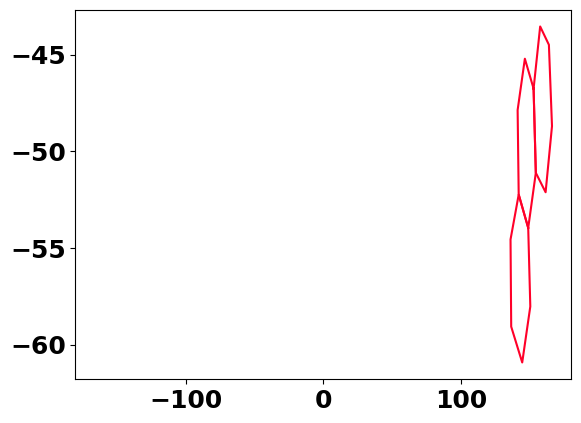

In [222]:
i=451
cluster=clusters[i]
cluster_color = list(scalarMapList[0][0:3])
if type(cluster) == Polygon:
    polyg=np.asarray(cluster.exterior.xy[::-1])
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    plt.plot(*polyg,color=cluster_color)
else:
    for geom in cluster.geoms:
        # Assert as numpy array from tuple
        polyg=np.asarray(geom.exterior.xy[::-1])
        # Fix: If the boundary crosses the 180/-180 meridian,
        #      extend the positive bound into <-180 longitude space
        #      (plotting doesn't appear to care here, otherwise it
        #       forces polygon to span the entire plot)
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        plt.plot(*polyg,color=cluster_color)
plt.xlim((-180.,180.))
plt.show()

In [223]:
import matplotlib.cm as cm
scalarMap = cm.ScalarMappable(cmap='gist_rainbow')
scalarMapList = scalarMap.to_rgba(range(32))

In [224]:
np.random.seed(90210)

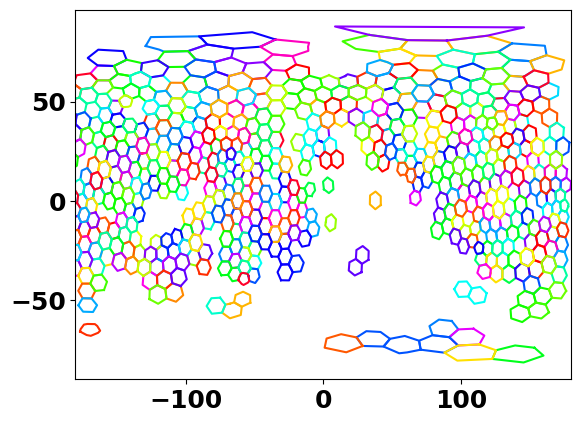

In [225]:
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        plt.plot(*polyg,color=cluster_color)
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            plt.plot(*polyg,color=cluster_color)
#plt.legend(['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7','cluster 8','cluster 9','cluster 10'])
plt.xlim((-180.,180.))
plt.show()

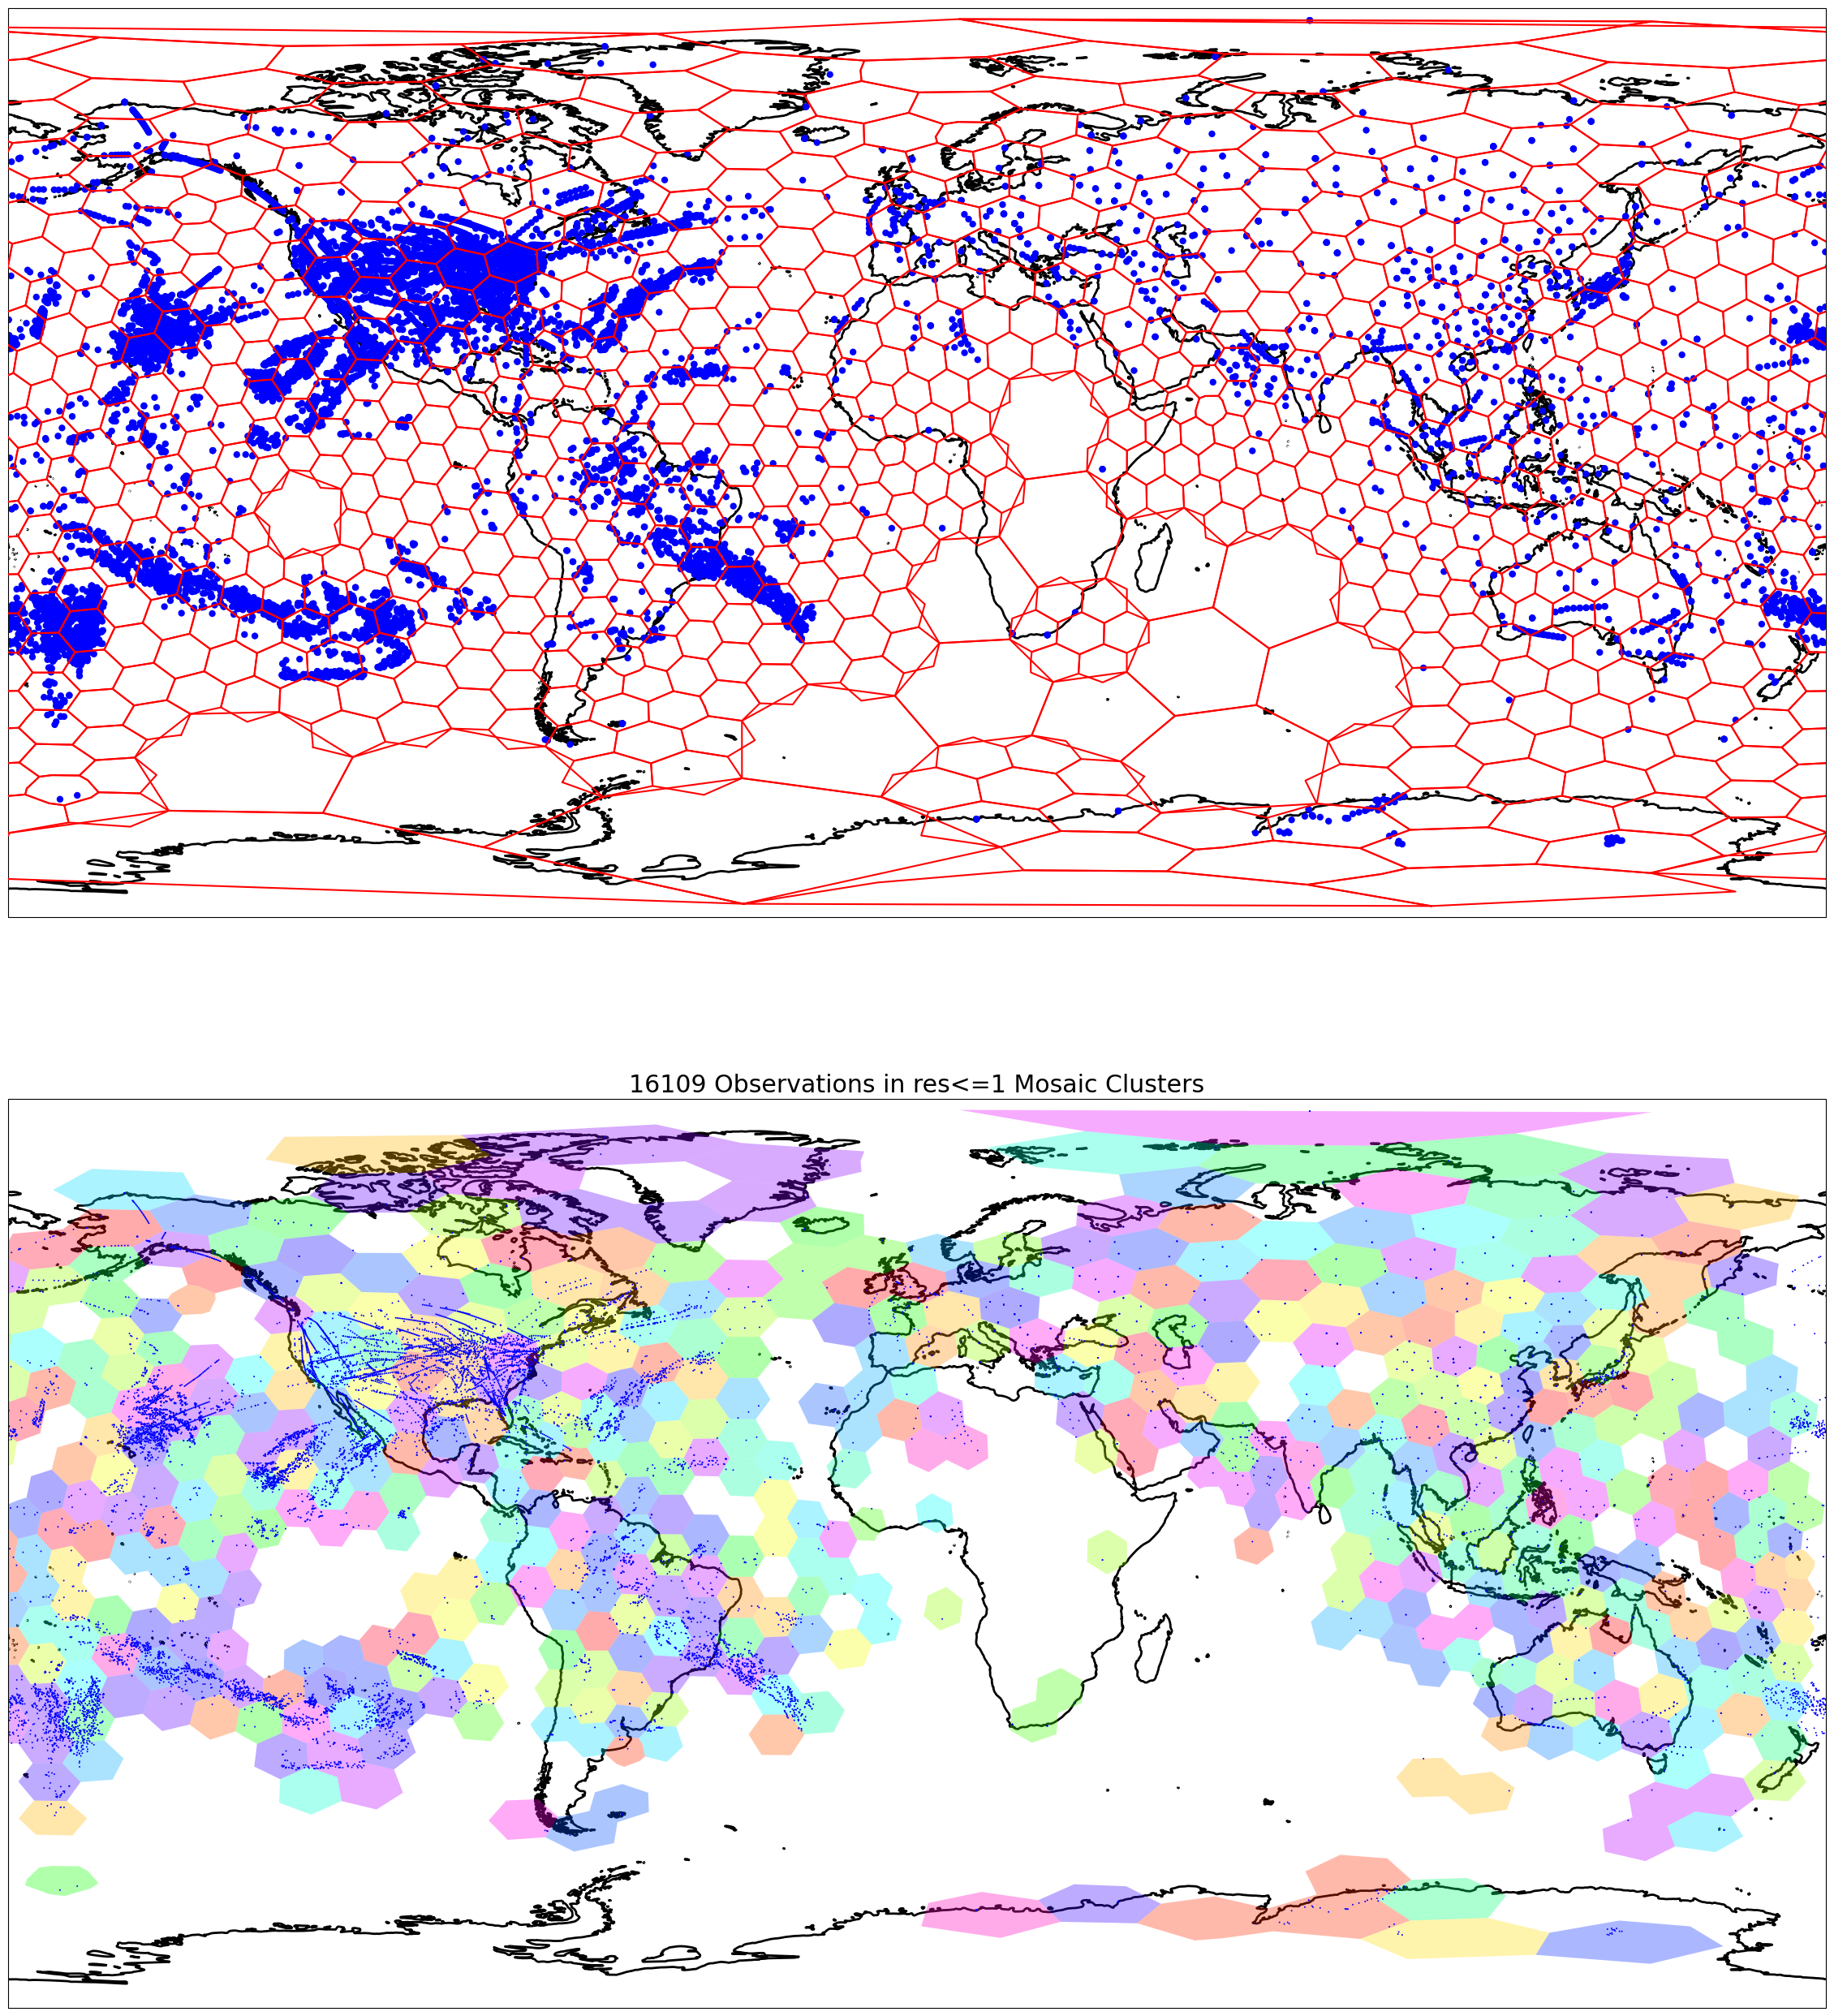

In [226]:
fig,(ax1,ax2)=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=2,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,32)
                   )

ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3MosaicMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax1.plot(*polyg,color='red',transform=proj,zorder=3)
# Plot obs data on top
sca=ax1.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=2
          )

ax2.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        ax2.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            ax2.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
# Plot obs data on top
sca=ax2.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           s=2,
           zorder=2
          )
ax2.set_global()
ax2.set_title('{:d} Observations in res<={:d} Mosaic Clusters'.format(np.size(idx),res))
plt.show()

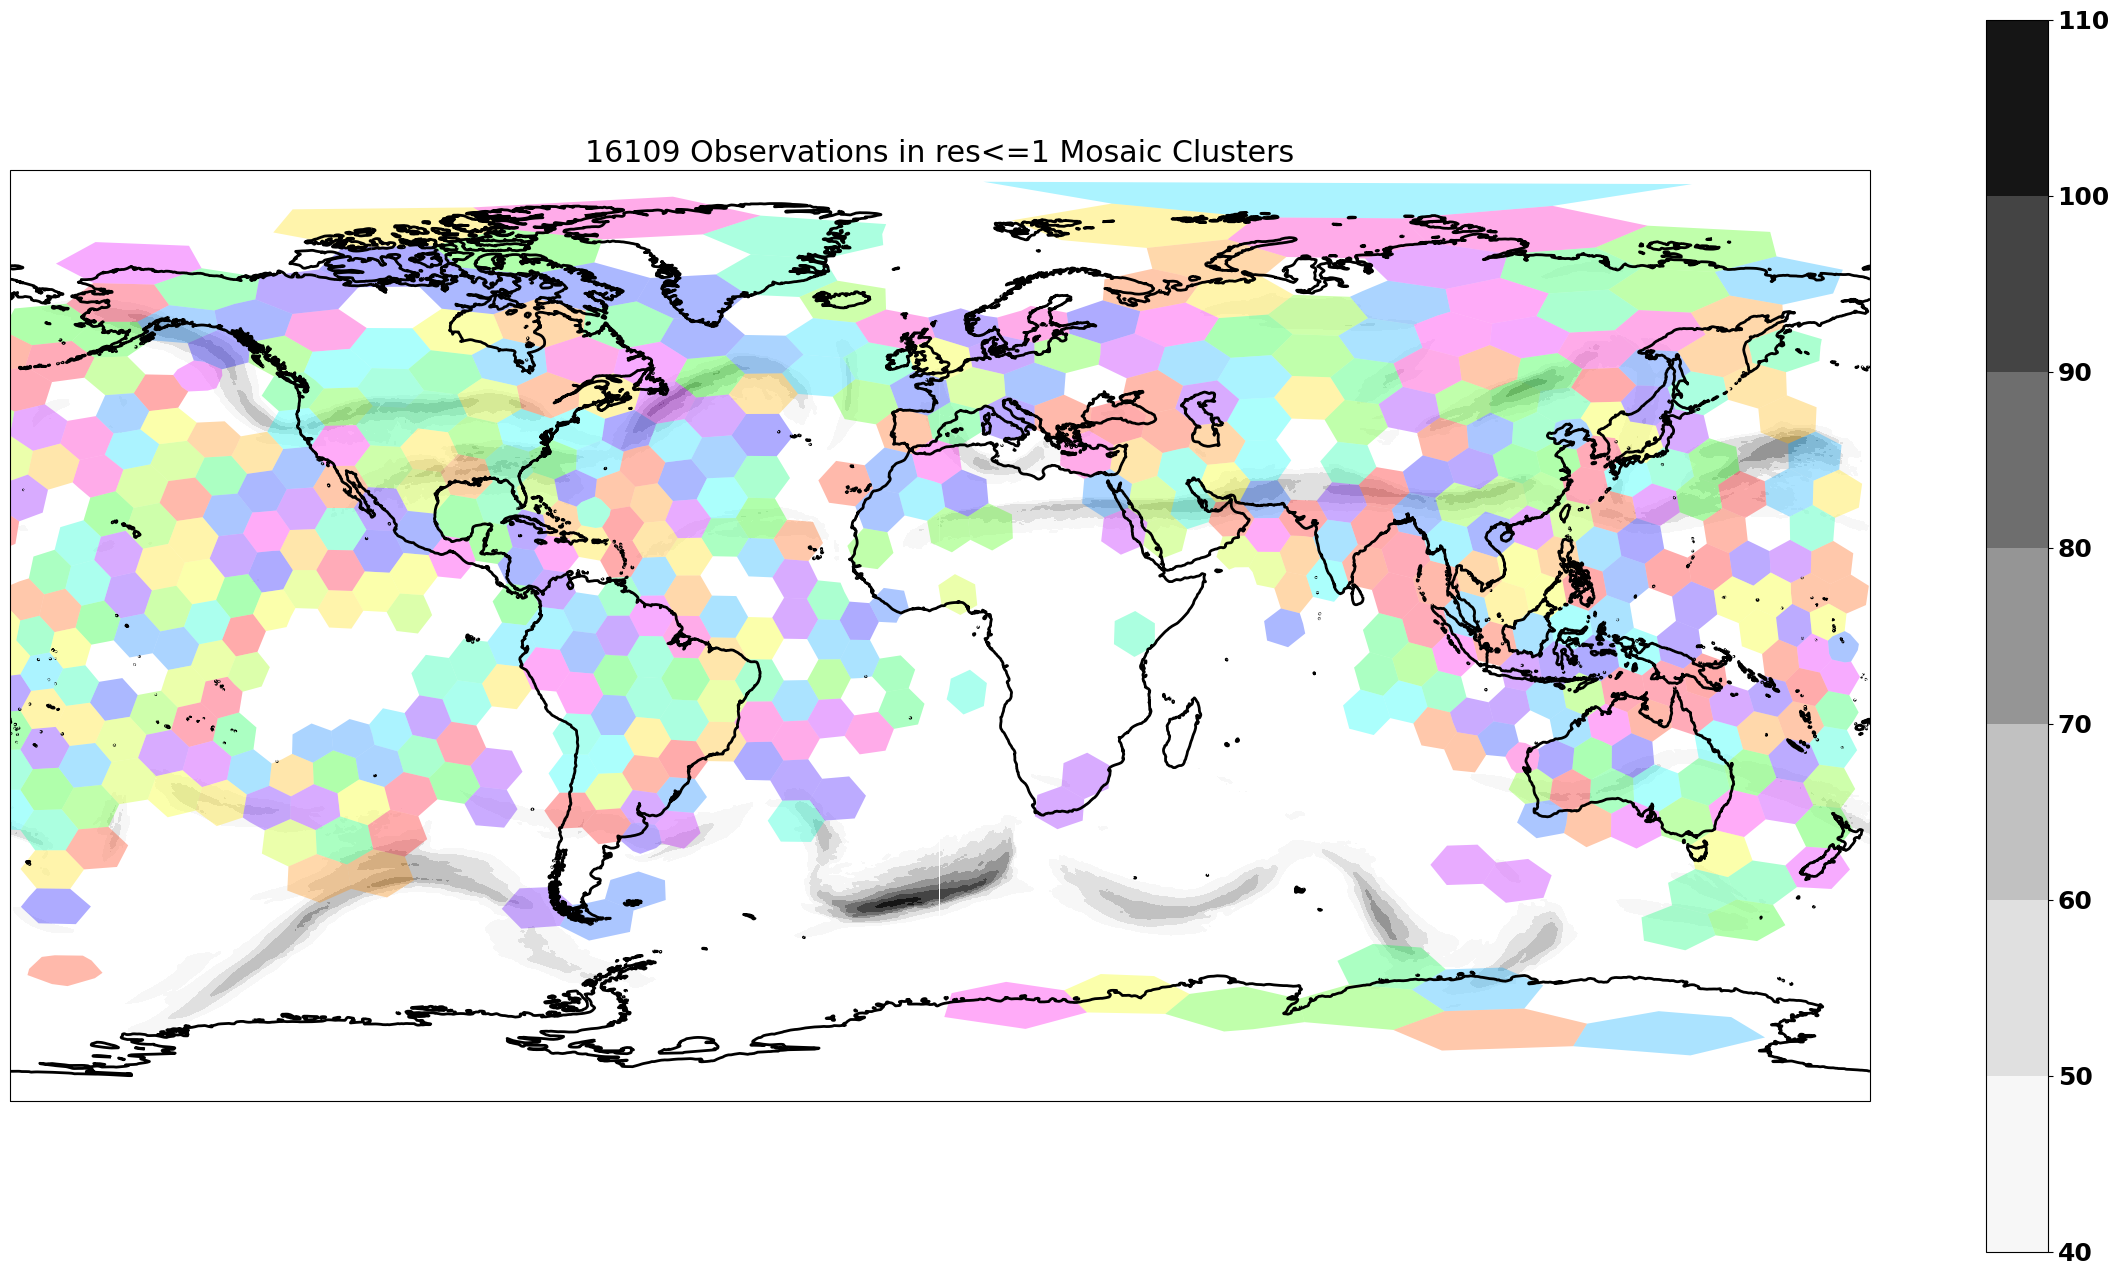

In [227]:
# Plot clusters over wind speed, do we see any relationship?
grib_spd=np.sqrt(grib_uwd**2.+grib_vwd**2.)
smin=40.
smax=110.
clevs=np.arange(smin,smax+0.1,10.)
fig,ax1=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=1,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,16)
                   )
ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=2)
shd=ax1.contourf(grib_lon,grib_lat,grib_spd,clevs,vmin=smin,vmax=smax,cmap='Greys',zorder=1)
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        ax1.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            ax1.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')

ax1.set_global()
ax1.set_title('{:d} Observations in res<={:d} Mosaic Clusters'.format(np.size(idx),res))
plt.colorbar(mappable=shd)
plt.show()

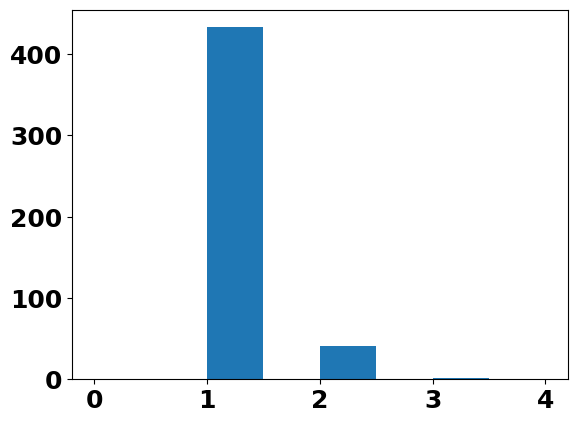

In [228]:
plt.hist(clusmems,np.arange(0.,np.max(clusmems)+1.1,0.5))
plt.show()

In [ ]:
# old stuff

In [113]:
cellframe['vavg'][np.where(np.asarray(model.labels_)==3)[0]]

0        5.200000
5        6.700000
10      -2.550000
33      -6.400000
34      -7.400000
          ...    
2977    25.948875
2978    26.112104
2979     8.101036
2988   -11.110637
2989   -10.953505
Name: vavg, Length: 260, dtype: float32

In [94]:
cluster.exterior.xy

(array('d', [22.88597142235973, 22.366711708487205, 22.454763494259407, 23.06040825069009, 23.579789173510154, 23.493392963974646, 22.88597142235973]),
 array('d', [-142.7188705783351, -142.2671031762863, -141.56432301662605, -141.30922197977063, -141.7580007453925, -142.46492855570392, -142.7188705783351]))

In [32]:
zrt = cdf[['geometry', 'h3_cell', 'n_obs']].join(u_av, on='h3_cell')\
                                 .dropna()
zrt

geometry             h3_cell  \
0     POLYGON ((5.59911 2.74972, 5.87309 3.20051, 6....  591529696601047039   
1     POLYGON ((5.59911 2.74972, 5.87309 3.20051, 6....  591529696601047039   
2     POLYGON ((14.21723 1.51237, 13.61891 1.60070, ...  591547013909184511   
3     POLYGON ((14.21723 1.51237, 13.61891 1.60070, ...  591547013909184511   
4     POLYGON ((42.40412 4.01018, 41.79113 4.11180, ...  590981658774077439   
...                                                 ...                 ...   
9750  POLYGON ((53.61758 -5.74309, 53.02395 -5.52248...  590417128272691199   
9751  POLYGON ((54.09043 -3.29718, 53.74271 -4.04475...  590416990833737727   
9752  POLYGON ((54.09043 -3.29718, 53.74271 -4.04475...  590416990833737727   
9753  POLYGON ((52.06043 -1.83011, 52.40232 -1.10349...  590417746747981823   
9754  POLYGON ((68.99305 -8.04953, 69.30416 -6.73119...  590097926303252479   

      n_obs     u-comp  
0       1.0  12.250000  
1       1.0  12.250000  
2       1.0  36.150000  
3       1.0  36.150000  
4       1.0   4.900000  
...     ...        ...  
9750    1.0  24.200000  
9751    1.0  27.866666  
9752    1.0  27.866666  
9753    1.0  26.750000  
9754    1.0  22.250000  

[9755 rows x 4 columns]

In [33]:
w=ps.lib.weights.contiguity.Queen.from_dataframe(zrt)

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/lib/weights/_contW_lists.py:20: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == 'polygon':
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/lib/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == 'linestring':
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 290 disconnected observations 
  Island ids: 58, 77, 143, 189, 191, 196, 200, 226, 232, 233, 234, 235, 249, 251, 252, 253, 260, 261, 262, 263, 266, 267, 269, 272, 273, 274, 275, 276, 277, 278, 281, 283, 284, 285, 286, 287, 300, 303, 304, 305, 306, 30

In [34]:
w

In [35]:
zrt

geometry             h3_cell  \
0     POLYGON ((5.59911 2.74972, 5.87309 3.20051, 6....  591529696601047039   
1     POLYGON ((5.59911 2.74972, 5.87309 3.20051, 6....  591529696601047039   
2     POLYGON ((14.21723 1.51237, 13.61891 1.60070, ...  591547013909184511   
3     POLYGON ((14.21723 1.51237, 13.61891 1.60070, ...  591547013909184511   
4     POLYGON ((42.40412 4.01018, 41.79113 4.11180, ...  590981658774077439   
...                                                 ...                 ...   
9750  POLYGON ((53.61758 -5.74309, 53.02395 -5.52248...  590417128272691199   
9751  POLYGON ((54.09043 -3.29718, 53.74271 -4.04475...  590416990833737727   
9752  POLYGON ((54.09043 -3.29718, 53.74271 -4.04475...  590416990833737727   
9753  POLYGON ((52.06043 -1.83011, 52.40232 -1.10349...  590417746747981823   
9754  POLYGON ((68.99305 -8.04953, 69.30416 -6.73119...  590097926303252479   

      n_obs     u-comp  
0       1.0  12.250000  
1       1.0  12.250000  
2       1.0  36.150000  
3       1.0  36.150000  
4       1.0   4.900000  
...     ...        ...  
9750    1.0  24.200000  
9751    1.0  27.866666  
9752    1.0  27.866666  
9753    1.0  26.750000  
9754    1.0  22.250000  

[9755 rows x 4 columns]

In [36]:
thr=1.0 # observations in a region

In [20]:
len(zrt)

9755

In [21]:

from spopt.region import MaxPHeuristic as MaxP

In [25]:
gdf.columns

Index(['geometry', 'lat', 'lon', 'ob_idx', 'h3_cell', 'u-comp', 'v-comp'], dtype='object')

In [41]:
# Set the seed for reproducibility
np.random.seed(1234)

z = zrt.drop(['geometry', 'h3_cell'], axis=1).values
maxp = MaxP(gdf=zrt,w=w, attrs_name=zrt.columns,threshold_name=('n_obs'), threshold=1., top_n=2, verbose=True)

In [42]:
maxp.solve()

ValueError: Unsupported dtype object

SystemError: initialization of _internal failed without raising an exception

In [44]:
import libpysal
pth = libpysal.examples.get_path("mexicojoin.shp")
mexico = gpd.read_file(pth)
mexico["count"] = 1

In [46]:
w = libpysal.weights.Queen.from_dataframe(mexico)

In [48]:
attrs_name = [f"PCGDP{year}" for year in range(1950, 2010, 10)]

In [49]:
threshold_name = "count"
threshold = 4

In [50]:
model = MaxPHeuristic(mexico, w, attrs_name, threshold_name, threshold)
model.solve()

In [51]:
w